In [2]:
import numpy as np
import netCDF4
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
from esem import rf_model
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors

# This is a local file, make sure you download it!
import utils

# make sure you have all packages
# pip install scikit-learn

####
# MUST DEFINE YOUR OWN PATH
# default path is "./dataset/"
####
data_path = "./dataset/"
utils.set_data_path(data_path)

In [3]:
train_files = ["historical", "ssp126", "ssp370", 'hist-aer', 'hist-GHG']
tasFiles = ["historical", "ssp126", "ssp370", "hist-aer", "hist-GHG"]
# Create training and testing arrays
X, solvers = utils.create_predictor_data(train_files)
Y = utils.create_predictdand_data(tasFiles)

In [4]:
rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='sqrt', **{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7,  'max_depth': 5,})
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='sqrt', **{'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 8,'max_depth': 40,})
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='sqrt',**{'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 12,'max_depth': 25,})
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='sqrt',**{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_depth': 20,})

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()

W0000 00:00:1764476498.777447   26683 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
X_test = utils.get_test_data('ssp245', solvers)
Y_test = utils.create_predictdand_data(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
dtr_truth = Y_test["diurnal_temperature_range"]
pr90_truth = Y_test["pr90"]

In [6]:
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)

In [7]:
print("tas:", utils.get_rmse(tas_truth, m_out_tas).mean())
print("pr:", utils.get_rmse(pr_truth, m_out_pr).mean())
print("dtr:", utils.get_rmse(dtr_truth, m_out_dtr).mean())
print("pr90:", utils.get_rmse(pr90_truth, m_out_pr90).mean())

tas: 0.8070222099365207
pr: 0.5586651385320317
dtr: 0.1698136235547545
pr90: 1.6372017806735872


In [8]:
def plot_rf_comparison(truth, emulated, varname, time_sel=2050, cmap="coolwarm", diff_cmap="PRGn", savefig=False):

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(21, 6), subplot_kw={"projection": ccrs.Robinson()})
    divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

    # --- True ---
    ax = axes[0]
    truth.sel(time=time_sel).plot(ax=ax, cmap=cmap, norm=divnorm, transform=ccrs.PlateCarree(), cbar_kwargs={"label":"Temperature change / K"})
    ax.set_title(f"{varname} True {time_sel}")
    ax.coastlines()

    # --- Emulated ---
    ax = axes[1]
    emulated.sel(sample=35).plot(ax=ax, cmap=cmap, norm=divnorm, transform=ccrs.PlateCarree(), cbar_kwargs={"label":"Temperature change / K"})
    ax.set_title(f"{varname} Pattern-Scaled {time_sel}")
    ax.coastlines()

    # --- Difference ---
    ax = axes[2]
    diff = truth.sel(time=time_sel) - emulated.sel(sample=35)
    diff.plot(ax=ax, cmap=diff_cmap, norm=divnorm, transform=ccrs.PlateCarree(), cbar_kwargs={"label":"Temperature change / K"})
    ax.set_title(f"{varname} Difference (True − Pattern-Scaled)")
    ax.coastlines()

    # Main title
    fig.suptitle(f"{varname} - Random Forests Comparison", fontsize=18)
    fig.tight_layout()

    # Save figure
    if savefig:
        fname = f"rf_{varname}_comparison.png"
        fig.savefig(fname, dpi=250, bbox_inches="tight")
        print(f"Saved figure: {fname}")

    plt.show()

Saved figure: rf_tas_comparison.png


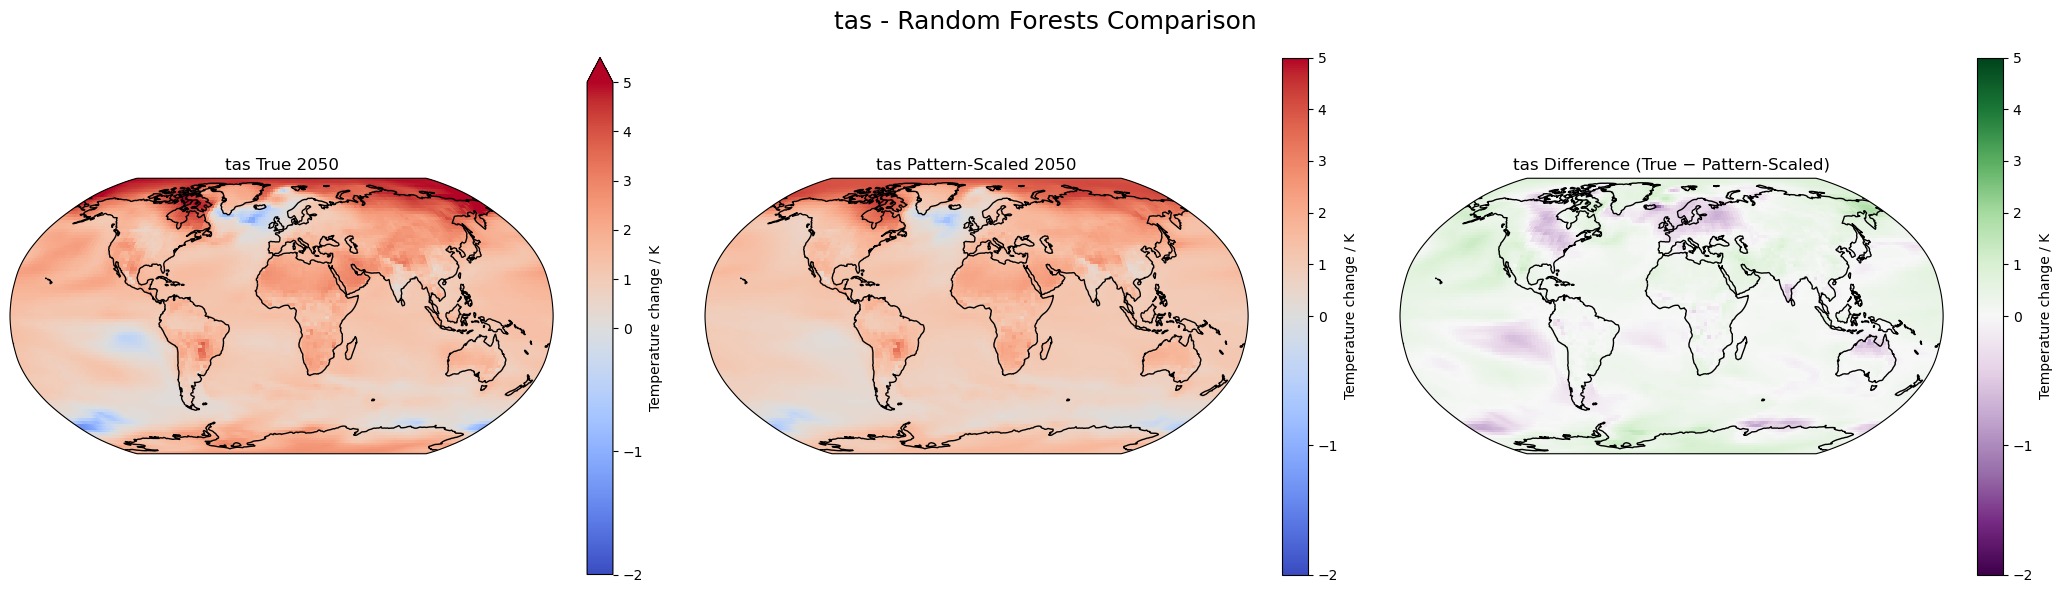

In [9]:
# hardcoded to show emulated 2050 (change sample=35)
plot_rf_comparison(truth=tas_truth, emulated=m_out_tas, varname="tas", time_sel=2050, cmap="coolwarm", diff_cmap="PRGn", savefig=True)